# Convolutional Neural Nets

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/ok-transformer/blob/master/docs/nb/dl/03-cnn.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/ok-transformer?style=social)](https://github.com/particle1331/ok-transformer)

---

**Readings:** [[CS231n]](https://cs231n.github.io/convolutional-networks/) [[NLPCourse | For You]](https://lena-voita.github.io/nlp_course/models/convolutional.html) {cite}`raschka2022`

## Introduction

In this notebook, we will apply **convolutions** to images and text embeddings. Convolutional networks were originally developed for computer vision tasks. Convolutions extract features by applying the same operation to local parts of an image. The motivation for this is that features in an image can be spatially perturbed without changing its meaning. These layers learn the presence of simple patterns such as blobs of horizontal lines. But stacking convolutional layers allow the network to learn heirarchical patterns that that generalize well to test data. 

Let us look at weights on the first layer of AlexNet {cite}`imagenet-paper`:

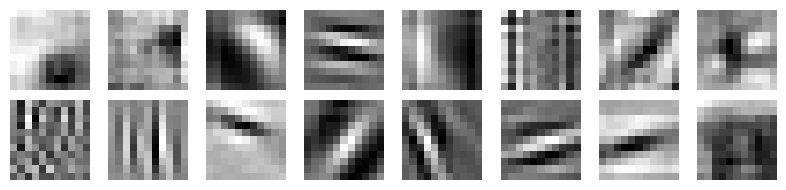

In [1]:
import torchvision.models as models
import matplotlib.pyplot as plt

alexnet = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
weights = alexnet.features[0].weight.data.detach().numpy()
weights = (weights - weights.min()) / (weights.max() - weights.min())

fig, ax = plt.subplots(2, 8, figsize=(8, 2))
for i in range(16):
    j, k = divmod(i, 8)
    ax[j, k].imshow(weights[i, 0, :, :].reshape(11, 11), cmap="gray")
    ax[j, k].axis('off')

fig.tight_layout()

In [2]:
del alexnet
del weights

<br>

We will also introduce **data augmentation** where transformed or perturbed versions 
of the original samples are used for training. This is important when the dataset is
small. We also define a reusable **training engine** which greatly simplifies training 
and inference code by removing large amounts of the usual boilerplate.

Importing modules used in this notebook:

In [3]:
import random
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib_inline import backend_inline

import torch
import torchvision
import torch.nn as nn

DATASET_DIR = Path("./data/").resolve()
warnings.simplefilter(action="ignore")
backend_inline.set_matplotlib_formats('svg')
matplotlib.rcParams["image.interpolation"] = "nearest"

RANDOM_SEED = 1
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

print(torch.__version__)
print(torch.backends.mps.is_built())
DEVICE = torch.device('mps')

2.0.0
True


## Convolution operation

Suppose we want to classify cat images using a linear model. Flattening the image into a vector 
and feeding it into a fully-connected network does not seem to be the best approach.
The linear layers discard important spatial information, i.e. permuting the input achieves the same result.
Moreover, the input vector would be too long resulting in a very large dense layer.

Notice that two pixels indicated in the left of {numref}`cat-conv` do not need to be mixed to figure out that the image is a cat. On the other hand, three nearby pixels on the right can form a linear combination that can be useful for determining cat-like features. This results in a very sparse banded weight matrix ({numref}`toeplitz`).

```{figure} ../../img/cat-conv.png
---
width: 40em
name: cat-conv
---
Nearby pixels constitute meaningful features of images.
```

Let $\boldsymbol{\mathsf X}$ be the input image and $\boldsymbol{\mathsf{S}}$ be the output feature map. Suppose $n^2 = |\boldsymbol{\mathsf X}|$ and $m^2 = |\boldsymbol{\mathsf{S}}|.$ Having a banded weight matrix reduces the nonzero entries of the weight matrix from $\mathcal{O}(m^2 n^2)$ to $\mathcal{O}(m^2{k}^2)$ where a local region of $k \times k$ pixels in the input are mixed. 
Moreover, we constrain the weights in each band to be **shared**.
This further reduces the number of weights to $k^2.$ The resulting linear operation is called a **convolution** written in two spatial dimensions as:

$$
\boldsymbol{\mathsf{S}} = (\boldsymbol{\mathsf X} \circledast \boldsymbol{\mathsf{K}})_{ij} = \sum_{x = 0}^{{k}-1} \sum_{y=0}^{{k}-1} {\boldsymbol{\mathsf X}}_{i + x, j + y} \, {\boldsymbol{\mathsf{K}}}_{xy}.
$$

Observe that spatial ordering of the pixels in the input $\boldsymbol{\mathsf X}$ is somewhat preserved in the output $\boldsymbol{\mathsf{S}}.$ This is nice since we want spatial information and orientation across a stack of convolution operations to be preserved in the final output.

```{margin}
Figure source:<br>
[`deepimaging.github.io`](https://deepimaging.github.io/lectures/lecture_9_intro_to_CNN's.pdf)
```
```{figure} ../../img/conv-cat-99.png
---
width: 30em
name: toeplitz
---
Banded Toeplitz matrix for classifying cat images. The horizontal vectors contain the same pixel values. The picture here is a bit inaccurate. There should be multiple bands if the kernel is 2-dimensional with size `k × k`. See this [SO answer](https://stackoverflow.com/a/44039201/1091950).
```

**Remark.** The following shows how convolutions work for 2D input. Each output pixel determines the amount the local input region is similar to the pattern in the kernel. Later we discuss stride and padding parameters for convolutions.


```{margin}
Source:
https://github.com/vdumoulin/conv_arithmetic
```
| | | | 
| :-----: | :-----:  | :-----: |
| no padding, no strides <br> ![](../../img/nn/no_padding_no_strides.gif) | no padding, strides <br> ![](../../img/nn/no_padding_strides.gif) | padding, strides <br> ![](../../img/nn/padding_strides.gif) |

### Convolution layer

Convolution layers extend the convolution operation to handle images with multiple **channels** (e.g. RGB). Similarly, we want to output feature maps with channels as this adds a further semantic dimension. The layer learns three-dimensional kernels $\boldsymbol{\mathsf{K}}_{kc}$ for each input-output channel pair. Note that features across input channels are blended by the kernel. The layer can be thought to learn **one feature extractor** for each **output channel**:

$$
\begin{aligned}
{\bar{\boldsymbol{\mathsf X}}}_{lij}
&= {\boldsymbol{\mathsf u}}_{l} + \sum_{c=0}^{{c}_\text{in}-1} ({\boldsymbol{\mathsf X}}_{[c,\,:,\, :]} \circledast {\boldsymbol{\mathsf K}}_{[l,\,{c},\, :,\,:]})_{ij} \\
&= {\boldsymbol{\mathsf u}}_{l} + \sum_{c=0}^{{c}_\text{in}-1}\sum_{x = 0}^{{k}-1} \sum_{y=0}^{{k}-1} {\boldsymbol{\mathsf X}}_{i + x,\, j + y,\, c} \, {\boldsymbol{\mathsf K}}_{lcxy} \\
\end{aligned}
$$

for $k = 0, \ldots, {c}_\text{out}-1$. The input and output tensors $\boldsymbol{\mathsf{X}}$ and $\bar{\boldsymbol{\mathsf{X}}}$ have the same dimensionality and semantic structure which makes sense since we want to stack convolutional layers as modules, and the kernel $\boldsymbol{\mathsf{K}}$ has shape $({c}_\text{out}, {c}_\text{in}, {k}, {k}).$ The resulting feature maps inherit the spatial ordering in its inputs along its spatial dimensions.

**Remark.** Note that this is 2D convolution since we are dealing with images (i.e. 2 spatial dimensions indexed by $i$ and $j$). 1D convolutions used in signal processing has one dimension for time.

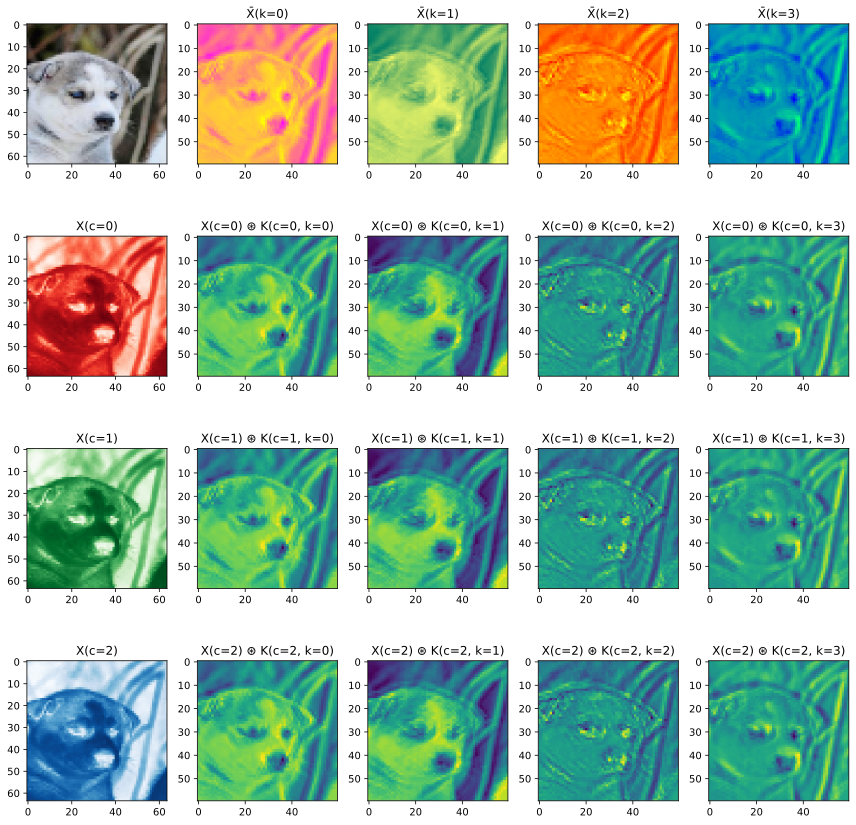

In [4]:
from torchvision.io import read_image
import torchvision.transforms.functional as fn


def conv_components(*, X, conv, act):
    """Components of a convolution of an RGB image with 4 output channels."""
    
    cmaps = ['Reds', 'Greens', 'Blues']
    cmaps_out = ['spring', 'summer', 'autumn', 'winter']

    # Get kernel weights
    K, u = conv.weight, conv.bias

    c_in  = X.shape[1]
    c_out = K.shape[0]

    # Iterate over in channels
    fig, ax = plt.subplots(c_in+1, c_out+1, figsize=(12, 12))
    ax[0, 0].imshow(X[0].permute(1, 2, 0))
    for c in range(c_in):
        ax[c+1, 0].set_title(f'X(c={c})')
        ax[c+1, 0].imshow(X[0, c, :, :], cmap=cmaps[c])

    # Iterate over kernel filters
    outs = {}
    for k in range(c_out):
        conv_k = nn.Conv2d(out_channels=1, in_channels=3, kernel_size=conv.kernel_size)
        T, v = conv_k.weight, conv_k.bias
        T.data = conv.weight[k:k+1, :, :, :]
        v.data = conv.bias[[k]]
        for c in range(c_in):
            outs[(c, k)] = conv_k(X)[0, 0, :, :]
            ax[c+1, k+1].imshow(outs[(c, k)].detach().numpy()) 
            ax[c+1, k+1].set_title(f"X(c={c}) ⊛ K(c={c}, k={k})")

    # Sum convolutions for each input channel
    for k in range(c_out):
        ax[0, k+1].imshow(sum([outs[(c, k)] for c in range(c_in)]).detach().numpy(), cmaps_out[k])
        ax[0, k+1].set_title(r"$\bar{\mathrm{X}}$" + f'(k={k})')

    fig.tight_layout()
    # return outs


cat = DATASET_DIR / "cat2dog/cat2dog/cat2dog/testB/270.jpg"
X = read_image(str(cat)).unsqueeze(0)
X = fn.resize(X, size=(64, 64)) / 255.
torch_conv = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=5)
conv_components(X=X, conv=torch_conv, act='');

**Figure.** Each kernel in entries `i,j > 0` combines column-wise with the inputs to compute `X(c=i) ⊛ K(c=i, k=j)`. The sum of these terms over `c` form the output map `X̅(k=j)` above. 
This looks similar to dense layers but with convolutions between 2D matrices instead of products between scalar nodes. This indicates that convnets perform combinatorial mixing of heirarchical features with depth.

The following checks if the formula is consistent with `Conv2d` in PyTorch:

Input shape:  torch.Size([1, 3, 64, 64])
Output shape: (1, 4, 60, 60)
Kernel shape: torch.Size([4, 3, 5, 5])
Bias shape:   torch.Size([4])
MAE (w/ pytorch) = 2.7022844738174476e-08

Output components (from scratch):


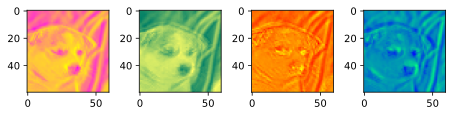

In [5]:
@np.vectorize
def np_relu(x):
    return max(0.0, x)

def scratch_conv(X, K, u):
    """Implementing a 2D convolutional layer from scratch."""

    h, w = K.shape[2:]
    B, c_in, H0, W0 = X.shape
    H1 = H0 - h + 1
    W1 = W0 - w + 1
    c_out = K.shape[0]

    S = np.zeros(shape=(B, c_out, H1, W1))
    for b in range(S.shape[0]):
        for k in range(S.shape[1]):
            for i in range(S.shape[2]):
                for j in range(S.shape[3]):
                    # Perform 3D convolution (c_in, h, w) for each out channel
                    S[b, k, i, j] = u[k] + (K[k, :, :, :] * X[b, :, i:i+h, j:j+w]).sum()
    return S


X = read_image(str(cat)).unsqueeze(0)
X = fn.resize(X, size=(64, 64)) / 255.
K = torch_conv.weight.data
u = torch_conv.bias.data
S = scratch_conv(X, K, u)
cmaps_out = ['spring', 'summer', 'autumn', 'winter']

print("Input shape: ", X.shape)   # (B, H_in,  W_in,  c_in)
print("Output shape:", S.shape)   # (B, H_out, W_out, c_out)
print("Kernel shape:", K.shape)   # (h, w, c_in, c_out)
print("Bias shape:  ", u.shape)   # (c_out,)

# Check if above formula agrees with PyTorch implementation
print("MAE (w/ pytorch) =", (torch.tensor(S) - torch_conv(X)).abs().mean().item())

# Plotting the images obtained using the above formula
print("\nOutput components (from scratch):")
fig, ax = plt.subplots(1, 4)
for k in range(4):
    ax[k].imshow(S[0, k, :, :], cmaps_out[k])
fig.tight_layout()

### Padding and stride

Convolutions can be modified to include a parameter called the **stride** that controls the step size of the kernel. A large stride along with a large kernel size can be useful if objects are large relative to the dimension of the image. Note that stride significantly reduces computation by constant factor. Strided convolutions have been used as an alternative way to downsample an image (i.e. works better or just as well as conv + pooling) {cite}`allconv`.

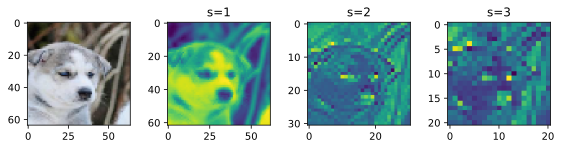

In [6]:
conv = lambda s: nn.Conv2d(in_channels=3, out_channels=3, stride=s, kernel_size=3)
fig, ax = plt.subplots(1, 4, figsize=(8, 2))

ax[0].imshow(X[0].permute(1, 2, 0))
ax[1].imshow(conv(1)(X)[0, 0].detach().numpy()); ax[1].set_title("s=1")
ax[2].imshow(conv(2)(X)[0, 0].detach().numpy()); ax[2].set_title("s=2")
ax[3].imshow(conv(3)(X)[0, 0].detach().numpy()); ax[3].set_title("s=3")
fig.tight_layout();

Notice that the spatial size decreases with stride. 
Moreover, central pixels are overrepresented since the kernels have to be kept within the input image. 
Information on the boundaries of the input become lost as we stack more convolutional layers. 

A simple solution that generally works well is **zero padding** the boundaries:

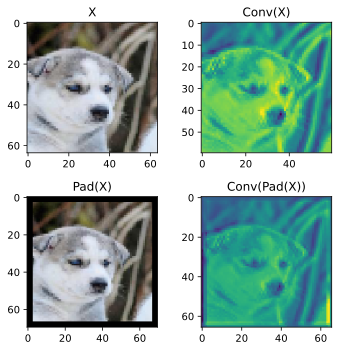

In [7]:
pad  = nn.ZeroPad2d(padding=3)
conv = torch_conv

fig, ax = plt.subplots(2, 2, figsize=(5, 5))
ax[1, 0].imshow(pad(X)[0].permute(1, 2, 0).detach());   ax[1, 0].set_title("Pad(X)")
ax[1, 1].imshow(conv(pad(X))[0, 0].detach());           ax[1, 1].set_title("Conv(Pad(X))")
ax[0, 0].imshow(X[0].permute(1, 2, 0).detach());        ax[0, 0].set_title("X")
ax[0, 1].imshow(conv(X)[0, 0].detach());                ax[0, 1].set_title("Conv(X)")
fig.tight_layout();

**Remark.** The input size is preserved by appropriately padding the input. Observe that padding has a weird effect on the boundary. For images with important boundaries, one can try **upsampling** (e.g. interpolation) as an alternative approach to get maintain output size.

### Output size

Padding and stride determines the spatial dimensions of the output feature maps. An input with width $w$ and equal padding $p$, and kernel size $k$ with stride $s$ has an output with width $\lfloor(w + 2p - k)/s + 1\rfloor$. In particular, we have to carefully choose stride and padding values so that the kernel can be placed evenly in the image with no input pixel dropped:

* For ${s} = 1,$ kernel size should be odd so that it covers the entire input in a symmetric manner. A common choice is $p = (k - 1)/2$ which results in same sized outputs (i.e. so-called **same convolution**). 

+++

* For ${s} > 1,$ the best practice is to choose a kernel size and the smallest $p$ such that $s$ divides $w + 2p - k$ so the entire input image is symmetrically covered by the kernel.

**Remark.** See `torchsummary` (or `torchinfo`) to automatically get the output size of each layer.

### Receptive field and pooling

The **receptive field** of a unit of a hidden layer consists of all units from previous layers that influences its value during forward pass. In particular, units for each class in the softmax layer should have a receptive field that includes the entire input. Otherwise, some parts of the input will not affect the prediction of the model for that class. These regions can be thought of as dead pixels or blind spots of the model for that class. 

```{margin}
Fig 14.2 in {cite}`geron2019hands-on`
```
```{figure} ../../img/receptive_field.png
---
width: 28em
---
Receptive field of a pixel in a convolutional network.
```

Receptive field can be exponentially increased by **pooling** or **downsampling** characterized by aggregating input pixels to make the dimensions of the image smaller for the next layer. This decreases the amount of computation and makes the model more robust to noise (sort of regularizes earlier outputs). This also means gradients are gated by pooling layers.

### Max pooling

Pooling layers downsample an input by performing nonparametric operations across the input like convolutional layers. There are also **global pooling** layers. Pooling is applied to each channel separately, so that the number of output channels is maintained. This makes sense since we want only to compress the original input without affecting its semantic structure.

```{margin}
Figure from: <br>
[`cs231n/conv-nets`](https://cs231n.github.io/convolutional-networks/)
```
```{figure} ../../img/pooling-cs231n.png
---
width: 300px

---

Pooling layer downsamples the volume spatially independently in each channel. The input tensor of size 224 × 224 × 64 is pooled with filter size 2 and stride 2 into output volume of size 112 × 112 × 64.
```

**Max pooling** makes the network tolerant to small noise or fine-grained details in the input at the cost of some information loss. It can also be interpreted as a form of competition between neurons since the gradient only flows through the activated neuron. A softer alternative is **average pooling**. 
Note that using pooling follows that intuition where we want to detect some patterns, but we do not care too much where exactly these patterns are ({numref}`03-pooling-text`).

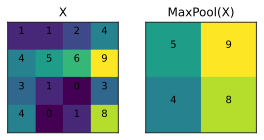

In [8]:
x = torch.tensor([
    [ 1, 1, 2, 4],
    [ 4, 5, 6, 9],
    [ 3, 1, 0, 3],
    [ 4, 0, 1, 8]]
)[None, None, :, :].float()

pool = nn.MaxPool2d(kernel_size=2, stride=2)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(4, 2))
ax[0].set_title("X")
ax[0].imshow(x.numpy()[0, 0, :, :], cmap='viridis', vmin=0)
ax[0].set_xticks([])
ax[0].set_yticks([])
for i in range(4):
    for j in range(4):
        ax[0].text(j, i, int(x[0, 0, i, j].numpy()), ha="center", va="bottom", color='black')

ax[1].set_title("MaxPool(X)")
ax[1].imshow(pool(x)[0].detach().permute(1, 2, 0), cmap='viridis', vmin=0)
ax[1].set_xticks([])
ax[1].set_yticks([])
for i in range(2):
    for j in range(2):
        ax[1].text(j, i, int(pool(x)[0, 0, i, j].numpy()), ha="center", va="bottom", color='black')

fig.tight_layout()

Commonly used settings are $k = 2, s = 2$ where the pooling regions are do not overlap, and the more aggressive overlapping pooling $k = 3, s = 2$. Observe that using too large kernel sizes can results in loss of discriminative information.

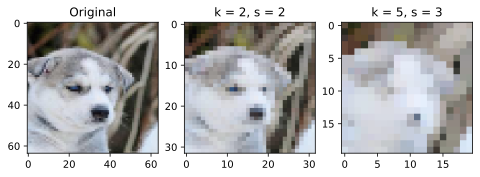

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(8, 3))
ax[0].imshow(X[0, :, :, :].permute(1, 2, 0))
ax[0].set_title("Original")
ax[1].imshow(nn.MaxPool2d(kernel_size=2, stride=2)(X)[0, :, :, :].permute(1, 2, 0))
ax[1].set_title("k = 2, s = 2")
ax[2].imshow(nn.MaxPool2d(kernel_size=5, stride=3)(X)[0, :, :, :].permute(1, 2, 0))
ax[2].set_title("k = 5, s = 3");

<br>

```{figure} ../../img/nn/03-pooling-text.png
---
width: 740px
name: 03-pooling-text
---

A typical convolutional model for texts consist of conv + pooling blocks. Here convolutions are applicable when we want to classify text using the presence of local features (e.g. certain phrases). [Source](https://lena-voita.github.io/nlp_course/models/convolutional.html)
```

## Convolutional networks

**Convolutional neural networks** (CNNs) typically stack conv+pool blocks. Note that using **blocks** composed of layers that together form a basic functional unit is generally used in designing NN architectures. Here the spatial dimensions are downsampled while increasing the number of output channels so that network capacity is not diminished. 

```{margin}
Source: <br>
[`github.com/rasbt/`](https://github.com/rasbt/machine-learning-book/blob/main/ch14/figures/14_12.png)
```
```{figure} ../../img/convnet.png
---
---
The architecture of our CNN network.
```

The first part of the network specializes in feature extraction. Feature representations are then passed to a fully-connected task-specific subnetwork. Here our task is classification, so we have the usual softmax at the end of the dense layers. For a large network trained on a sufficiently large dataset (e.g. AlexNet on ImageNet), the learned features can be **transferred** to other tasks by [fine-tuning](https://keras.io/guides/transfer_learning/).

In [10]:
import torchsummary 

mnist_model = lambda: nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=5, padding=2),
    nn.SELU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.SELU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Flatten(),
    nn.Linear(64*7*7, 512),
    nn.SELU(),
    nn.Dropout(0.5),
    nn.Linear(512, 10)
)

torchsummary.summary(mnist_model(), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
              SELU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
              SELU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
           Flatten-7                 [-1, 3136]               0
            Linear-8                  [-1, 512]       1,606,144
              SELU-9                  [-1, 512]               0
          Dropout-10                  [-1, 512]               0
           Linear-11                   [-1, 10]           5,130
Total params: 1,630,602
Trainable params: 1,630,602
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

**Remark.** We use **SELU activation** {cite}`selu` for fun. Note that we also used **Dropout** {cite}`dropout` as regularization for the dense layers. These will be discussed in a future notebook in this series. Observe that convolutions have negligible contribution (<1.5%) to the number of parameters of the network!

### Training

Setting up MNIST data loaders:

In [11]:
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import random_split, DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x / 255.)
])

mnist_all = MNIST(root=DATASET_DIR, download=False, transform=transform)
mnist_train, mnist_valid = random_split(
    mnist_all, [55000, 5000], 
    generator=torch.Generator().manual_seed(RANDOM_SEED)
)

dl_train = DataLoader(mnist_train, batch_size=32, shuffle=True) # (!)
dl_valid = DataLoader(mnist_valid, batch_size=32, shuffle=False)

**Remark.** `shuffle=True` is important for SGD training. The model had low validation score when looping through the samples in the same order (subtle bug in a previous commit). This may be due to cyclic behavior in the updates (i.e. cancelling out).

Setting up training:

In [12]:
from tqdm import tqdm_notebook as tqdm
import torch.nn.functional as F

model = mnist_model().to(DEVICE)
loss_fn = lambda logits, y: F.cross_entropy(logits, y)
optim = torch.optim.Adam(model.parameters(), lr=0.001)

losses = []
accuracy = []
for epoch in tqdm(range(10)):
    for x, y in dl_train:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        logits = model(x)
        loss = loss_fn(logits, y)
        loss.backward()
        optim.step()
        optim.zero_grad()
        losses.append(loss.item())

    # Do not generate computational graph
    with torch.no_grad():
        model.eval()
        acc = 0.0
        for x, y in dl_valid:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            logits = model(x)
            acc += (logits.argmax(dim=1) == y).float().sum().item()
        
        model.train()
        acc = acc / len(dl_valid.dataset)
        accuracy.append(acc)
        print(f"Epoch {epoch}:   val_acc={acc:.3f}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0:   val_acc=0.941
Epoch 1:   val_acc=0.969
Epoch 2:   val_acc=0.974
Epoch 3:   val_acc=0.974
Epoch 4:   val_acc=0.981
Epoch 5:   val_acc=0.979
Epoch 6:   val_acc=0.978
Epoch 7:   val_acc=0.980
Epoch 8:   val_acc=0.985
Epoch 9:   val_acc=0.983


Training curves:

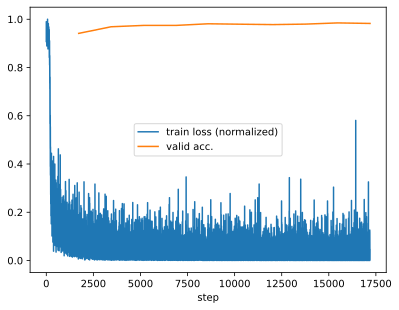

In [13]:
num_epochs = 10
steps_per_epoch = len(losses) // num_epochs
plt.xlabel("step")
plt.plot(np.array(losses) / max(losses), label="train loss (normalized)")
plt.plot(range(steps_per_epoch, steps_per_epoch * (num_epochs + 1), steps_per_epoch), accuracy, label="valid acc.")
plt.legend();

**Remark.** SELU performance is surprising (it also trains really fast). That self-normalizing bit is no joke.

### Feature maps

Let us visualize how an input is transformed into feature maps as it passes through the network during training. Note that the filters shown are truncated to 5 each layer for lack of space.

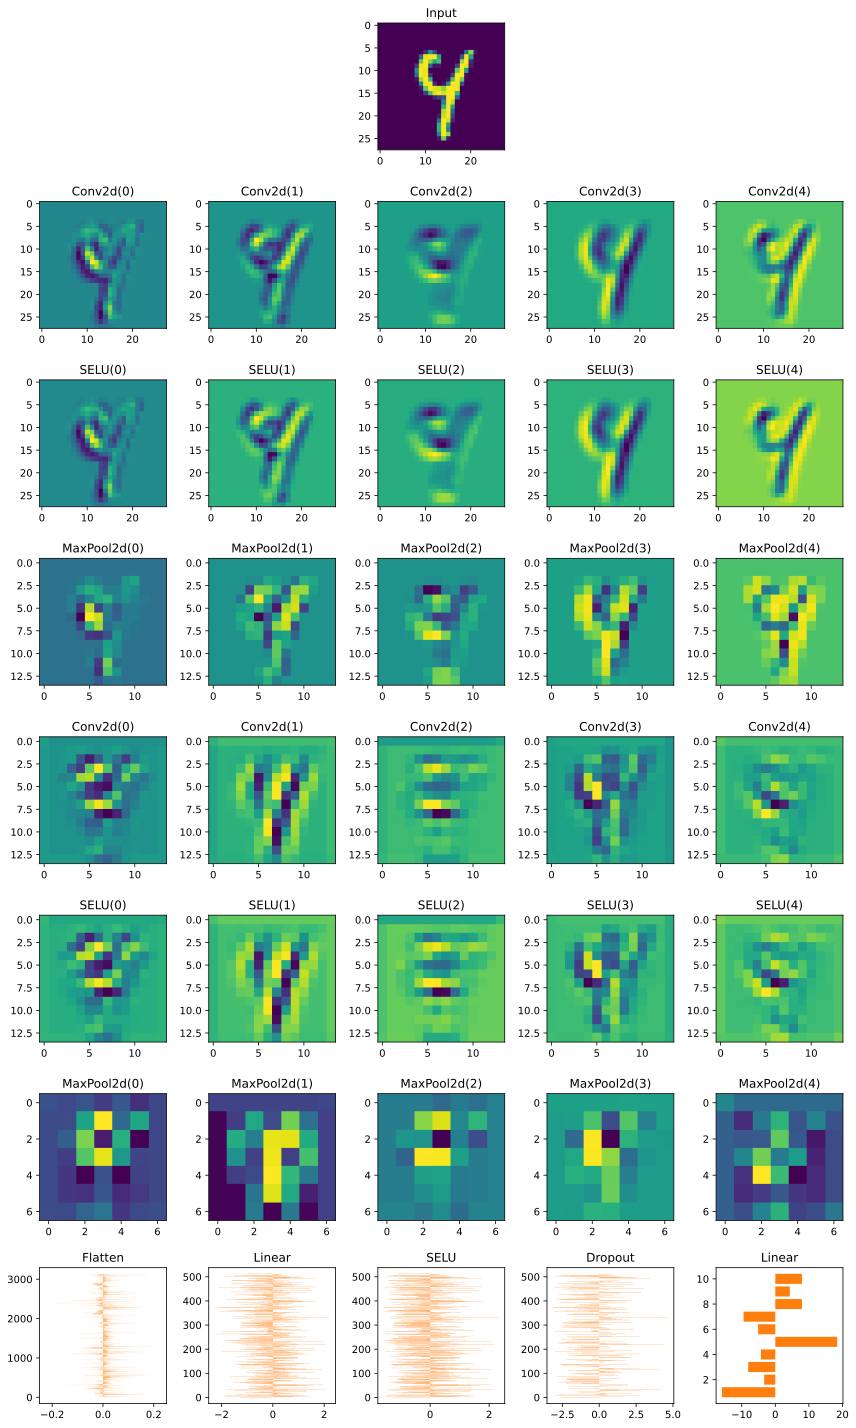

In [14]:
x, y = next(iter(dl_valid))
b = 5
x = x[b:b+1, :].to(DEVICE)

fig, ax = plt.subplots(8, 5, figsize=(12, 20))
ax[0, 2].set_title("Input")
ax[0, 2].imshow(x[0, 0].cpu().detach().numpy())
ax[0, 0].set_axis_off()
ax[0, 1].set_axis_off()
ax[0, 3].set_axis_off()
ax[0, 4].set_axis_off()

for k in range(6):
    x = model[k](x)
    for j in range(5):
        ax[k+1, j].set_title(type(model[k]).__name__ + f"({j})")
        ax[k+1, j].imshow(x[0, j].cpu().detach().numpy())

for l in range(5):
    x = model[6+l](x)
    ax[7, l].set_title(type(model[6+l]).__name__)
    ax[7, l].barh(range(1, x.shape[1]+1), x[0].cpu().detach().numpy(), color="C1")

fig.tight_layout()

**Figure.** Each input feature map of a convolutional layer is used to create each output feature map. Max-pooling and ReLU on the other hand just passes feature maps downward.

Model predicts the correct label:

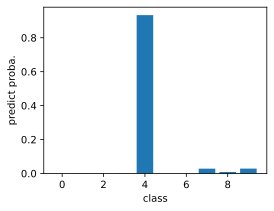

In [15]:
import torch.nn.functional as F
temp = 3.0
plt.figure(figsize=(4, 3))
plt.bar(range(10), F.softmax(x/temp, dim=1).detach().cpu()[0])
plt.xlabel("class")
plt.ylabel("predict proba.");

## Data augmentation

MNIST is not representative of real-world datasets. The images are nicely centered and instances belonging to the same class have similar scales. In this section, we will create a CNN for classifying smiling faces on a more complex dataset. Moreover, we use only use a small subset consisting of 16,000 faces in [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) {cite}`celeb_a`.

### Transforms

This dataset is relatively small for the given task. To make the model perform well, we have to use **data augmentation**. This technique incorporates transformed or perturbed versions of the original images into the dataset. More precisely, each data point
$(\boldsymbol{\mathsf{x}}, y)$ in a mini-batch is replaced by $(T(\boldsymbol{\mathsf{x}}), y)$ during training
where $T$ is a stochastic label preserving transformation. At inference, an input $\boldsymbol{\mathsf{x}}$ is replaced by $\mathbb{E}[T(\boldsymbol{\mathsf{x}})].$

In [16]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomCrop([178, 178]),
    transforms.RandomHorizontalFlip(),
    transforms.Resize([64, 64]),
])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop([178, 178]),
    transforms.Resize([64, 64]),
])

Note that the transformations must be label preserving. Here we randomly crop and flip versions of the original images. Cropping has the effect of perturbing the position of a smile by a small amount. Flipping makes sense since the face has mirror symmetry. Augmentation is built into data loaders with stochastic transforms:

In [17]:
from torchvision.datasets import CelebA
from torch.utils.data import Subset

get_smile = lambda attr: attr[31].item() # hacks (see list_attr_celeba.txt)
celeba_train = CelebA(DATASET_DIR, download=True, split="train", target_type="attr", transform=transform_train, target_transform=get_smile)
celeba_valid = CelebA(DATASET_DIR, download=True, split="valid", target_type="attr", transform=transform,       target_transform=get_smile)
celeba_test  = CelebA(DATASET_DIR, download=True, split="test",  target_type="attr", transform=transform,       target_transform=get_smile)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Roughly balanced classes:

In [18]:
for dt in [celeba_train, celeba_valid, celeba_test]:
    s = 0
    for img, tgt in dt:
        s += tgt
    print(f"{s / len(dt):.3f}")

0.480
0.483
0.500


Simulating images across epochs:

In [19]:
simul_train = DataLoader(Subset(celeba_train, torch.arange(3)), batch_size=1, shuffle=True)
simul_valid = DataLoader(Subset(celeba_valid, torch.arange(1)), batch_size=1, shuffle=False)
simul_test  = DataLoader(Subset(celeba_test,  torch.arange(1)), batch_size=1, shuffle=False)

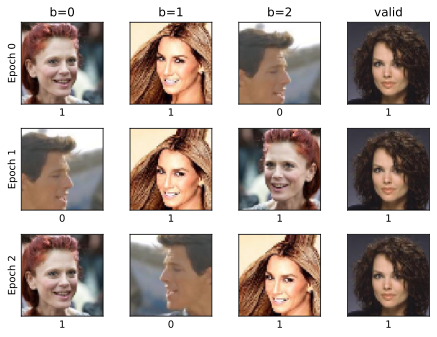

In [20]:
fig, ax = plt.subplots(3, 4)
for e in range(3):
    for i, (img, tgt) in enumerate(simul_train):
        if i == 0:
            ax[e, i].set_ylabel(f"Epoch {e}")
        ax[e, i].imshow(img[0].permute(1, 2, 0).detach())
        ax[e, i].set_xlabel(tgt[0].item())
        ax[e, i].set_xticks([])
        ax[e, i].set_yticks([])
        ax[0, i].set_title(f"b={i}")

    img_val, tgt_val = next(iter(simul_valid))
    ax[e, 3].set_xlabel(tgt_val[0].item())
    ax[e, 3].imshow(img_val[0].permute(1, 2, 0).detach())
    ax[e, 3].set_xticks([])
    ax[e, 3].set_yticks([])

ax[0, 3].set_title('valid')
fig.tight_layout()

**Figure.** Inputs are stochastically transformed at each epoch. Note that the labels are not affected (both at the recognition and implementation level). The test and validation sets have fixed transformations implementing sort of the expectation of the random transformations.

## Training engine

Here we define a **trainer engine** that allows us to cleanly separate different concerns during model training. We use the [torchmetrics](https://torchmetrics.readthedocs.io/en/stable/) library to clean up metric computation. These are stateful which explains the use of the `.update` and `.compute` methods. We also define `eval_context` to automatically set the model to eval mode at entry, and back to the default train mode at exit. This is useful for layers such as BN and Dropout which have different behaviors at train and test times.

In [21]:
import torchmetrics
from contextlib import contextmanager
from torch.utils.data import DataLoader


class Trainer:
    def __init__(self, model, optim, loss_fn, device=DEVICE, verbose=True):
        self.model = model.to(device)
        self.optim = optim
        self.device = device
        self.loss_fn = loss_fn
        self.train_log = {'loss': [], 'accs': [], 'loss_avg': [], 'accs_avg': []}
        self.valid_log = {'loss': [], 'accs': []}
        self.verbose = verbose
    
    def __call__(self, x):
        return self.model(x.to(self.device))

    def forward(self, batch):
        x, y = batch
        x = x.to(self.device)
        y = y.to(self.device)
        return self.model(x), y

    def train_step(self, batch):
        preds, y = self.forward(batch)
        accs = (preds.argmax(dim=1) == y).float().mean()
        loss = self.loss_fn(preds, y)
        loss.backward()
        self.optim.step()
        self.optim.zero_grad()
        return {'loss': loss, 'accs': accs}

    @torch.no_grad()
    def valid_step(self, batch):
        preds, y = self.forward(batch)
        accs = (preds.argmax(dim=1) == y).float().sum()
        loss = self.loss_fn(preds, y, reduction='sum')
        return {'loss': loss, 'accs': accs}
    
    def run(self, epochs, data_module):
        self.train_log['loss'] = []
        self.train_log['accs'] = []
        self.valid_log['loss'] = []
        self.valid_log['accs'] = []

        loss_metric = torchmetrics.MeanMetric().to(self.device)
        accs_metric = torchmetrics.MeanMetric().to(self.device)

        for e in tqdm(range(epochs)):
            for batch in data_module.train:
                output = self.train_step(batch)

                # logs @ train step
                loss_metric.update(output['loss'])
                accs_metric.update(output['accs'])
                self.train_log['loss'].append(output['loss'].item())
                self.train_log['accs'].append(output['accs'].item())
                self.train_log['loss_avg'].append(loss_metric.compute().item())
                self.train_log['accs_avg'].append(accs_metric.compute().item())

            # logs @ epoch
            output = self.evaluate(data_module.valid)
            self.valid_log['loss'].append(output['loss'])
            self.valid_log['accs'].append(output['accs'])
            if self.verbose:
                print(f"[Epoch: {e+1:>0{int(len(str(epochs)))}d}/{epochs}]    loss: {self.train_log['loss_avg'][-1]:.4f}    val_loss: {self.valid_log['loss'][-1]:.4f}    val_acc: {self.valid_log['accs'][-1]:.4f}")
    
    @contextmanager
    def eval_context(self):
        self.model.eval()
        try:
            yield
        finally:
            self.model.train()

    def evaluate(self, data_loader):
        with self.eval_context():
            valid_loss = 0.0
            valid_accs = 0.0
            for batch in data_loader:
                output = self.valid_step(batch)
                valid_loss += output['loss'].item()
                valid_accs += output['accs'].item()

        return {
            'loss': valid_loss / len(data_loader.dataset),
            'accs': valid_accs / len(data_loader.dataset)
        }

    @torch.no_grad()
    def predict(self, x: torch.Tensor):
        with self.eval_context():
            return self(x)

    @torch.no_grad()
    def batch_predict(self, input_loader: DataLoader):
        with self.eval_context():
            preds = [self(x) for x in input_loader]
            preds = torch.cat(preds, dim=0)
        return preds

The `predict` method is suited for inference over *one* transformed mini-batch. A model call over a large input tensor may cause memory error. The model does not generate a computational graph to conserve memory and calls the layers in eval mode. For large batches, one should use `batch_predict` which takes in a data loader with transforms.

In [22]:
model = nn.Sequential(nn.Linear(3, 10), nn.Dropout(0.99))
trainer = Trainer(model, optim=None, loss_fn=None)

# inference mode using eval_context
x = torch.ones(size=(1, 3), requires_grad=True)
print(f"__call__    {(trainer(x) > 0).float().mean():.3f}")
print(f"predict     {(trainer.predict(x) > 0).float().mean():.3f}")

__call__    0.000
predict     0.600


Checking computational graph generation:

In [23]:
y = trainer(x)
z = y.sum()
z.backward()
print('__call__   ', x.grad)

try:
    y = trainer.predict(x)
    z = y.sum()
    z.backward()
except RuntimeError:
    print("predict    ", "No gradients!")

__call__    tensor([[ 8.3430, 10.8665,  0.9805]])
predict     No gradients!


## CNN + GAP network

Our network architecture is similar to the MNIST network above. But here we use **global average-pooling** (GAP) which averages all pixels in the 8 × 8 feature map into a single pixel. This makes the model more robust to small spatial translations in the input. Note that this preserves the channel structure resulting in reduced output vector of length 256. This vector is then passed to a dense layer to perform classification.

In [24]:
def celeba_model(): 
    model = nn.Sequential()

    model.add_module('conv1', nn.Conv2d(3, 64, kernel_size=5, padding=3))
    model.add_module('norm1', nn.BatchNorm2d(64))
    model.add_module('relu1', nn.ReLU())
    model.add_module('pool1', nn.MaxPool2d(kernel_size=2))

    model.add_module('conv2', nn.Conv2d(64, 128, kernel_size=3, padding=1))
    model.add_module('norm2', nn.BatchNorm2d(128))
    model.add_module('relu2', nn.ReLU())
    model.add_module('pool2', nn.MaxPool2d(kernel_size=2))

    model.add_module('conv3', nn.Conv2d(128, 128, kernel_size=3, padding=1))
    model.add_module('norm3', nn.BatchNorm2d(128))
    model.add_module('relu3', nn.ReLU())
    model.add_module('pool3', nn.MaxPool2d(kernel_size=2))
    
    model.add_module('conv4', nn.Conv2d(128, 256, kernel_size=3, padding=1))
    model.add_module('norm4', nn.BatchNorm2d(256))
    model.add_module('relu4', nn.ReLU())
    model.add_module('pool4', nn.AvgPool2d(kernel_size=8))
    
    model.add_module('flatten', nn.Flatten())
    model.add_module('fc', nn.Linear(256, 2))

    return model


torchsummary.summary(celeba_model(), input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 66, 66]           4,864
       BatchNorm2d-2           [-1, 64, 66, 66]             128
              ReLU-3           [-1, 64, 66, 66]               0
         MaxPool2d-4           [-1, 64, 33, 33]               0
            Conv2d-5          [-1, 128, 33, 33]          73,856
       BatchNorm2d-6          [-1, 128, 33, 33]             256
              ReLU-7          [-1, 128, 33, 33]               0
         MaxPool2d-8          [-1, 128, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]         147,584
      BatchNorm2d-10          [-1, 128, 16, 16]             256
             ReLU-11          [-1, 128, 16, 16]               0
        MaxPool2d-12            [-1, 128, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         295,168
      BatchNorm2d-14            [-1, 25

**Remark.** This network is fairly deep, so we use **batch normalization** (BN) {cite}`batchnorm` to aid with activation and gradient stability. BN is discussed in more detail in a future notebook. Notice that the network is fairly small (only ~500K params). This is allowed by the GAP layer.

### Model training

Combining the data loaders into one module:

In [25]:
import torch.nn.functional as F
from torchmetrics import Accuracy

class CelebADataModule:
    def __init__(self, batch_size):
        
        self.train = DataLoader(
            Subset(celeba_train, torch.arange(16000)),
            batch_size=batch_size, 
            shuffle=True
        )

        self.valid = DataLoader(
            Subset(celeba_valid, torch.arange(1000)), 
            batch_size=batch_size, 
            shuffle=False
        )
    
        self.test = DataLoader(
            Subset(celeba_test, torch.arange(1000)), 
            batch_size=batch_size, 
            shuffle=False
        )

Training the model using Adam {cite}`adam` with a learning rate of `0.01` and a batch size 32:

In [26]:
celeba_dm = CelebADataModule(batch_size=32)
model = celeba_model()
optim = torch.optim.Adam(model.parameters(), lr=0.01)
trainer = Trainer(model, optim, loss_fn=F.cross_entropy)
trainer.run(epochs=25, data_module=celeba_dm)

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 01/25]    loss: 0.6832    val_loss: 0.8187    val_acc: 0.5150
[Epoch: 02/25]    loss: 0.6333    val_loss: 1.1081    val_acc: 0.5780
[Epoch: 03/25]    loss: 0.5302    val_loss: 0.2869    val_acc: 0.8760
[Epoch: 04/25]    loss: 0.4631    val_loss: 0.4091    val_acc: 0.8210
[Epoch: 05/25]    loss: 0.4190    val_loss: 0.2379    val_acc: 0.8960
[Epoch: 06/25]    loss: 0.3870    val_loss: 0.2712    val_acc: 0.8870
[Epoch: 07/25]    loss: 0.3636    val_loss: 0.2567    val_acc: 0.8800
[Epoch: 08/25]    loss: 0.3448    val_loss: 0.2642    val_acc: 0.8820
[Epoch: 09/25]    loss: 0.3292    val_loss: 0.4577    val_acc: 0.8220
[Epoch: 10/25]    loss: 0.3164    val_loss: 0.3070    val_acc: 0.8630
[Epoch: 11/25]    loss: 0.3051    val_loss: 0.2367    val_acc: 0.9130
[Epoch: 12/25]    loss: 0.2957    val_loss: 0.2467    val_acc: 0.9000
[Epoch: 13/25]    loss: 0.2875    val_loss: 0.2264    val_acc: 0.9150
[Epoch: 14/25]    loss: 0.2802    val_loss: 0.2128    val_acc: 0.9090
[Epoch: 15/25]    lo

**Remark.** Training can be interrupted at any point without any issues.

In [27]:
def plot_training_history(trainer):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    num_epochs = len(trainer.valid_log['accs'])
    num_steps_per_epoch = len(trainer.train_log['accs']) // num_epochs
    ax[0].plot(trainer.train_log['loss'], alpha=0.3, color="C0")
    ax[1].plot(trainer.train_log['accs'], alpha=0.3, color="C0")
    ax[0].plot(trainer.train_log['loss_avg'], label='train', color="C0")
    ax[1].plot(trainer.train_log['accs_avg'], label='train', color="C0")
    ax[0].plot(list(range(num_steps_per_epoch, (num_epochs + 1) * num_steps_per_epoch, num_steps_per_epoch)), trainer.valid_log['loss'], label='valid', color="C1")
    ax[1].plot(list(range(num_steps_per_epoch, (num_epochs + 1) * num_steps_per_epoch, num_steps_per_epoch)), trainer.valid_log['accs'], label='valid', color="C1")
    ax[0].set_xlabel('step')
    ax[0].set_ylabel('loss')
    ax[0].grid(linestyle='dashed', alpha=0.3)
    ax[0].legend()
    ax[1].set_xlabel('step')
    ax[1].set_ylabel('accuracy')
    ax[1].grid(linestyle='dashed', alpha=0.3)
    ax[1].legend()
    
    fig.tight_layout();

Note that the validation step uses sum reduction to accumulate results over a validation epoch for a fixed set of weights. This simulates inference performance if we load the trained model at that **checkpoint**. On the other hand, train metrics are expensive since the training dataset is large. Hence, these are accumulated at each step as a simple running average (also possible is an exponential running average). 

These should be kept in mind when looking at the training history plot:

```{margin}
<br> <br> <br> <br> <br> <br> <br> <br>
![](../../img/nn/soyjak-points.png) <br>
Double descent! (?) Probably just imprecise
batchnorm stats.
```

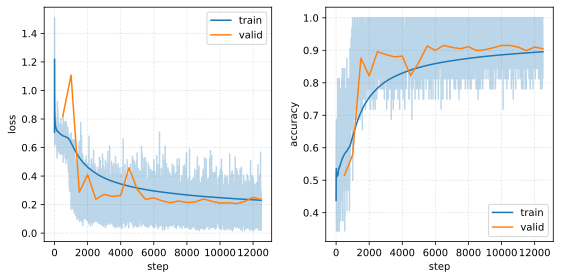

In [28]:
plot_training_history(trainer)

**Remark.** Note that if we turn off data augmentation the validation curves diverge and the model overfits very early in the training (i.e. model memorizes the training data). Data augmentation prevents this by adding noise in the input. The model also does not train without BN layers. A side-effect of BN is that validation looks wonky since batch statistics estimated using EMA are imprecise due to weights changing throughout the course of training. See Fig 3. of {cite}`precisebn`.

Final test performance can be computed as follows:

In [29]:
trainer.evaluate(celeba_dm.test)

{'loss': 0.2086284323334694, 'accs': 0.923}

### Inference

The trainer `predict` method takes a tensor of shape instead and loads it by batch for inference. That is, it does not just call `self.model(x)` on an input `x` which is a problem for large models. It is assumed that `dim=0` of `x` is the batch dimension. This is the best method to use for trained model inference:

In [30]:
class InputDataLoader(DataLoader):
    def __init__(self, data_loader):
        self.data_loader = data_loader

    def __iter__(self):
        for batch in self.data_loader:
            yield batch[0]


probs = trainer.batch_predict(InputDataLoader(celeba_dm.valid))
probs

tensor([[ 1.4053, -1.4249],
        [-0.2660,  0.2395],
        [ 4.6543, -4.6245],
        ...,
        [-9.5291,  9.4690],
        [ 2.0521, -2.0574],
        [ 0.1441, -0.1805]], device='mps:0')

This should be equal to the final validation accuracy:

In [31]:
y = torch.cat([batch[1] for batch in celeba_dm.valid], dim=0)
print((probs.argmax(dim=1) == y.to(DEVICE)).float().mean().item())
print(trainer.evaluate(celeba_dm.valid)['accs'])
print(trainer.valid_log['accs'][-1])

0.9050000309944153
0.905
0.905


**Remark.** It is important to note when deploying the models that data points in our data loader come transformed. For a batch of new images `X` in the wild, we have to call the eval mode transformation `transform(X)`:

In [32]:
celeba_valid_notransform = CelebA(DATASET_DIR, download=False, split="valid", target_type="attr")
xt, _ = next(iter(celeba_valid))
xn, _ = next(iter(celeba_valid_notransform))

print(trainer.predict(transform(xn).unsqueeze(0)))
print(trainer.predict(xt.unsqueeze(0)))

tensor([[ 1.4053, -1.4249]], device='mps:0')
tensor([[ 1.4053, -1.4249]], device='mps:0')


### Visualization: CAM

```{figure} ../../img/cams.png
---
---
{cite}`cams` GAP layer flattens the final feature map by collapsing its spatial dimensions. Here the first kernel detects something around the seatbelt or chest area. This however turns out to be irrelevant (i.e. $\mathsf{w}_1 \approx 0$) for the Australian terrier class as can be seen in the final heatmap.
```



The last layer in our GAP-CNN network is a linear combination of the average pixel values of the last feature map. Our network has 256 output channels in the last kernel which is interpreted as precisely features that the network detects to determine the class of the image. Since spatial orientation is preserved up to the final layer, the activations of the last kernel can be projected to the input into a sort of heatmap. 

The resulting map is called the class activation map (CAMs) {cite}`cams`. To
construct the CAM for class $j$, we use the learned weights ${\mathsf{w}}_{i j}$ on the final feature map $f_k(\boldsymbol{\mathsf{x}})$ of shape $(8,8)$ for $k=1, \ldots, 256$:

$$\mathsf{CAM}(\boldsymbol{\mathsf{x}}, j)= \text{ReLU}\left(\sum_{k=1}^{256} f_k(\boldsymbol{\mathsf{x}})\, {\mathsf{w}}_{k j}\right).$$

Here we use ReLU since we only want activations that contribute to the given class. The resulting 8×8 image is resized to the same height and width the input image $\boldsymbol{\mathsf{x}}$:

In [33]:
from functools import reduce

@torch.no_grad()
def compute_cam(trainer, x, t, b=1):
    """CAM of one instance taken with respect to the predicted label.
    Note that this function has no access to the ground truth label."""
    
    class_weight = trainer.model[-1].weight         # (m, 256) where m = 2 (binary)
    x = torch.tensor(x).to(DEVICE)
    with trainer.eval_context():
        detectors = list(trainer.model.modules())[1:-3]
        act_map = reduce(lambda x, f: f(x), detectors, x)
    
    weights = class_weight[t]                       # (B, 256)
    cam = act_map * weights.view(-1, 256, 1, 1)     # (B, 256, 8, 8) * (B, 256, 1, 1)
    cam = F.relu(cam.sum(dim=1, keepdim=True))      # (B, 1, 8, 8)

    return cam

**Remark.** A generalization of CAM that is architecture agnostic is **Grad-CAM** {cite}`gradcam` that uses gradients of class nodes with respect to activation pixels. 

Plotting constructed CAMs for test examples:


In [34]:
@torch.no_grad()
def plot_cam(trainer, x, t, height=96, width=96):
    """Plot class activation maps (CAM) wrt. predicted label for each image in batch."""

    class_label = {0: 'Not Smile', 1: 'Smile'}
    resize = transforms.Resize(size=(height, width))

    x = x.to(DEVICE)
    img = resize(x)
    cam = compute_cam(trainer, x, t)

    t = [t] * len(x)
    probs = F.softmax(trainer.predict(x), dim=1)
    
    fig, ax = plt.subplots(1, 6, figsize=(12, 4))
    for b in range(6):
        heatmap = cam[b].detach().cpu()
        heatmap = resize(heatmap).permute(1, 2, 0)
        heatmap = heatmap.detach().cpu()
        ax[b].imshow(img[b].permute(1, 2, 0).detach().cpu())
        ax[b].imshow(heatmap, alpha=0.70, cmap='jet', interpolation='sinc', 
            vmin=0.0, vmax=10.0) # (!) Setting [vmin, vmax] is important! (Otherwise, color is relative)   
        ax[b].set_xlabel(f"Pr({class_label[t[b]]})={probs[b][t[b]].item()*100:.2f}%", color='black')
        ax[b].set_xticks([])
        ax[b].set_yticks([])

    fig.tight_layout()

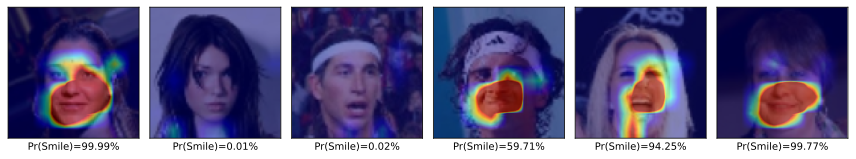

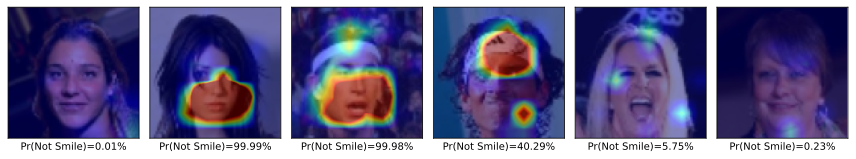

In [35]:
X, Y = next(iter(celeba_dm.test))
X = X.to(DEVICE)
plot_cam(trainer, X[12:18], t=1) # smile activation
plot_cam(trainer, X[12:18], t=0) # not smile activation

**Figure.** CAMs of test images for the smile class (top) and the not class (bottom). Red indicates positive activation towards the respective class. In general, activations occur around facial features.

For all images, we see pixels around the mouth region activates for both smile and not smile classes which makes sense. Since the CAMs alternate between the two classes, we can infer that these correspond to two distinct set of kernels. Indeed, the plot below shows that the weights of a kernel are negatively correlated between the two classes:

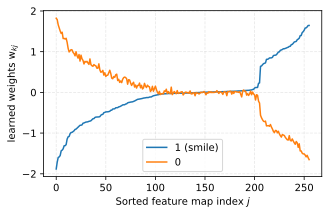

In [36]:
class_weight = trainer.model[-1].weight
h = class_weight[1].argsort()
plt.figure(figsize=(5, 3))
plt.plot(class_weight[1][h].detach().cpu().numpy(), label='1 (smile)')
plt.plot(class_weight[0][h].detach().cpu().numpy(), label='0')
plt.legend()
plt.grid(linestyle="dashed", alpha=0.3)
plt.xlabel('Sorted feature map index $j$')
plt.ylabel('learned weights $\mathsf{w}_{kj}$');

This is a nice property of the CNN-GAP network: its last CNN layer learns abstract features that are particular for the presence or not of a smile. Smile detectors are those with positive weights for the positive class and negative weights for the negative class, and vice-versa for the not-smile detectors. The model also learns that certain features are not predictive of either class.

## Text classification

In this section, we train a CNN on text embeddings. In particular, our dataset consist of [US names](https://www.kaggle.com/datasets/kaggle/us-baby-names/) downloaded from Kaggle. Our task will be to classify names into its gender label given in the dataset.

In [37]:
df = pd.read_csv(DATASET_DIR / "NationalNames.csv")
print("nan count:", df.isna().sum().sum())
df['Name'] = df['Name'].map(lambda s: s.lower())
df.head()

nan count: 0


Id       Name  Year Gender  Count
0   1       mary  1880      F   7065
1   2       anna  1880      F   2604
2   3       emma  1880      F   2003
3   4  elizabeth  1880      F   1939
4   5     minnie  1880      F   1746

In [38]:
df.Gender.value_counts()

Gender
F    1081683
M     743750
Name: count, dtype: int64

Note that we push all names even those with two labels:

In [39]:
dataset = set()
for n, g in zip(df.Name.tolist(), df.Gender.tolist()):
    dataset.add((n, g))

label_map = {"F": 1, "M": 0}
names = []  # X
label = []  # y
for n, g in dataset:
    names.append(n)
    label.append(label_map[g])

len(names), len(label)

(104110, 104110)

Some label imbalance:

In [40]:
from collections import Counter
g_count = Counter(label)
print("M:", g_count[0])
print("F:", g_count[1])

M: 39199
F: 64911


Looking at name lengths:

Max name length: 15


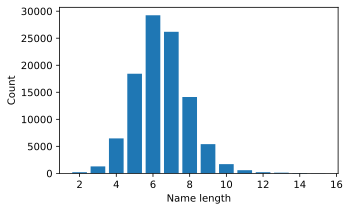

In [41]:
name_length = Counter([len(n) for n in names])
lengths = sorted(name_length.keys())
plt.figure(figsize=(5, 3))
plt.bar(lengths, [name_length[k] for k in lengths])
plt.xlabel("Name length")
plt.ylabel("Count")
print("Max name length:", max(lengths))

We will pad names with `.` at the end so that we get same length names. Moreover, we will truncate names to a max length. This is typical for language models due to architectural constraints. In any case, considering a sufficiently large fixed number of initial characters of a name should be enough to determine the label.

In [42]:
MAX_LEN = 12    # captures almost all names
CHARS = ['.'] + sorted(list(set([c.lower() for n in names for c in n])))
VOCAB_SIZE = len(CHARS)

print("token count:", VOCAB_SIZE)
print("".join(CHARS))

token count: 27
.abcdefghijklmnopqrstuvwxyz


In [43]:
def preprocess(name):
    out = [c.lower() for c in name if c in CHARS]
    return "." + "".join(out)[:min(len(out), MAX_LEN)] + "." * (MAX_LEN - len(out))

preprocess("joey")

'.joey........'

### Data loaders

In [44]:
from torch.utils.data import Dataset, DataLoader

class NamesDataset(Dataset):
    def __init__(self, names: list[str], label: list[int]):
        self.char_to_int = {char: i for i, char in enumerate(CHARS)}
        self.data = torch.tensor([self.encode(name) for name in names])
        self.label = torch.tensor(label)

    def encode(self, name: str):
        return [self.char_to_int[char] for char in preprocess(name)]

    def decode(self, x: torch.Tensor):
        int_to_char = {i: c for c, i in self.char_to_int.items()}
        return "".join(int_to_char[i.item()] for i in x)
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]


class NamesDataModule:
    def __init__(self, names, label, train_ratio=0.8, batch_size=32, seed=0):
        g = torch.Generator().manual_seed(seed)
        self.dataset = NamesDataset(names, label)
        train, valid = random_split(self.dataset, [train_ratio, 1 - train_ratio], generator=g)
        self.train = DataLoader(train, batch_size=batch_size, shuffle=True)
        self.valid = DataLoader(valid, batch_size=batch_size, shuffle=False)


names_dm = NamesDataModule(names, label)

Sample instance:

In [45]:
x, y = next(iter(names_dm.train))
x[0], y[0]

(tensor([ 0, 19,  8,  5, 22,  5, 12, 12,  5,  0,  0,  0,  0]), tensor(1))

Decoding:

In [46]:
name = names_dm.dataset.decode(x[0])
gender = {i: g for g, i in label_map.items()}[y[0].item()]
name, gender

('.shevelle....', 'F')

### Model

For each token (i.e. character in `CHARS`) we learn an embedding vector in $\mathbb{R}^{10}.$ The convolution kernel runs across 3 of these with stride 1. Names are short, so 3 should be a good number. This is implemented below with a 1D convolution with kernel size 3 times the embedding size, and a stride equal to the embedding size ({numref}`03-text-cnn`). 

```{figure} ../../img/nn/03-text-cnn.png
---
width: 740px
name: 03-text-cnn
---

Model architecture to classify text using convolutions. The kernel slides over embeddings instead of pixels. [Source](https://lena-voita.github.io/nlp_course/models/convolutional.html#text_classification)
```

Hence, the model determines the gender label of a name by looking at the presence of certain trigrams in a name. This is also why we **max pool over time** ({numref}`03-maxpool-over-time`) since we do not care where these trigrams occur in a name. This reduces the feature map to a vector of length equal to the output channel of the 1D convolution.

```{figure} ../../img/nn/03-maxpool-over-time.png
---
width: 500px
name: 03-maxpool-over-time
---

Max pooling over time reduces the feature map to a vector whose entries correspond to the largest value in each output channel over the entire sequence. [Source](https://lena-voita.github.io/nlp_course/models/convolutional.html#text_classification)
```

**Remark.** Why do we use embeddings an not just use, say, one-hot representations? This is because some characters are similar in the context of this task. The model gets to learn this during training by learning the weights of the embedding matrix.

In [47]:
import torchinfo

class CNNModel(nn.Module):
    def __init__(self, vocab_size=VOCAB_SIZE, context=3, embedding_dim=10, conv_width=64, fc_width=256):
        super().__init__()
        self.vocab_size = vocab_size
        self.emb = embedding_dim
        self.context = context

        self.C = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.conv1 = nn.Conv1d(1, conv_width, kernel_size=3*embedding_dim, stride=embedding_dim)
        self.relu1 = nn.ReLU()
        self.pool_over_time = nn.MaxPool1d(kernel_size=MAX_LEN-1)

        self.fc = nn.Sequential(
            nn.Linear(conv_width, fc_width),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(fc_width, 2)
        )

    def forward(self, x):
        B = x.shape[0]
        x = self.C(x)
        x = x.reshape(B, 1, -1)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool_over_time(x)
        return self.fc(x.reshape(B, -1))


torchinfo.summary(CNNModel(), input_size=(1, MAX_LEN + 1), dtypes=[torch.int64])

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [1, 2]                    --
├─Embedding: 1-1                         [1, 13, 10]               270
├─Conv1d: 1-2                            [1, 64, 11]               1,984
├─ReLU: 1-3                              [1, 64, 11]               --
├─MaxPool1d: 1-4                         [1, 64, 1]                --
├─Sequential: 1-5                        [1, 2]                    --
│    └─Linear: 2-1                       [1, 256]                  16,640
│    └─ReLU: 2-2                         [1, 256]                  --
│    └─Dropout: 2-3                      [1, 256]                  --
│    └─Linear: 2-4                       [1, 2]                    514
Total params: 19,408
Trainable params: 19,408
Non-trainable params: 0
Total mult-adds (M): 0.04
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.08
Estimated Total Size (MB): 0.09

### Training

In [48]:
model = CNNModel(conv_width=128, fc_width=256)
optim = torch.optim.Adam(model.parameters(), lr=0.001)
trainer = Trainer(model, optim, loss_fn=F.cross_entropy)
trainer.run(epochs=5, data_module=names_dm)

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 1/5]    loss: 0.4774    val_loss: 0.4476    val_acc: 0.7933
[Epoch: 2/5]    loss: 0.4593    val_loss: 0.4335    val_acc: 0.7967
[Epoch: 3/5]    loss: 0.4493    val_loss: 0.4249    val_acc: 0.8028
[Epoch: 4/5]    loss: 0.4427    val_loss: 0.4278    val_acc: 0.8018
[Epoch: 5/5]    loss: 0.4376    val_loss: 0.4185    val_acc: 0.8072


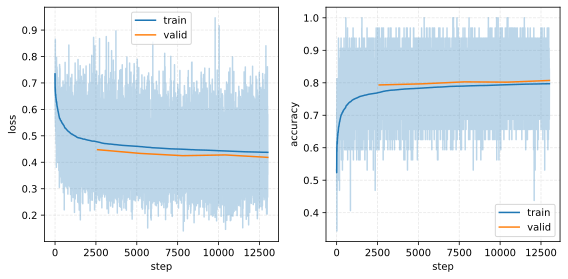

In [49]:
plot_training_history(trainer)

### Inference

In [50]:
data = [ 
    "justine",
    "ericka",
    "justine ericka"
]

# Model prediction
x = torch.tensor([names_dm.dataset.encode(n) for n in data])
probs = F.softmax(trainer.predict(x), dim=1)[:, 1].cpu()  # p(F|name)

In [51]:
print("name                   p(F|name)")
print("--------------------------------")
for i, name in enumerate(data):
    print(f"{name + ' ' * (MAX_LEN - len(name))} \t\t {probs[i]:.3f}")

name                   p(F|name)
--------------------------------
justine      		 0.815
ericka       		 0.930
justine ericka 		 0.812


---
■